# Importing Libraries 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import seaborn as sns 
import cv2 
from PIL import Image 
from tqdm import tqdm
import keras 
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
import tensorflow.keras.backend as k
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Read and Display Images

In [2]:
folder=os.listdir('/kaggle/input/brain-tumor-segmentation')
folder

['images', 'masks']

In [3]:
# make a list of image and mask filenames 
image_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

print(image_files[:10])
print(mask_files[:10])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [4]:
def display_image_mask(image_path,mask_path):
    count=0
    for image_file,mask_file in zip(image_files,mask_files):
        if count>=6:
            break
        image_path_full=os.path.join(image_path,image_file)
        mask_path_full=os.path.join(mask_path,mask_file)

        image=cv2.imread(image_path_full)
        mask=cv2.imread(mask_path_full,cv2.IMREAD_GRAYSCALE)

        if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
        if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

        mask_3ch=cv2.merge([mask,mask,mask])
        image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')

        plt.subplot(1,3,3) 
        overlay = cv2.addWeighted(image_rgb, 0.7, mask_3ch, 0.3, 0)
        plt.imshow(overlay)
        plt.title("Image with overlay")

        plt.show()
        count+=1

In [5]:
image_path='/kaggle/input/brain-tumor-segmentation/images'
mask_path='/kaggle/input/brain-tumor-segmentation/masks'

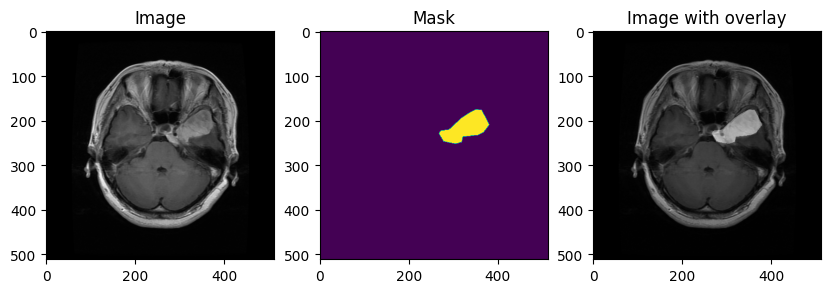

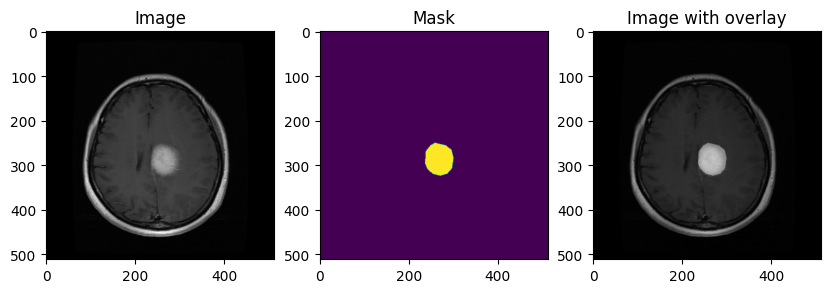

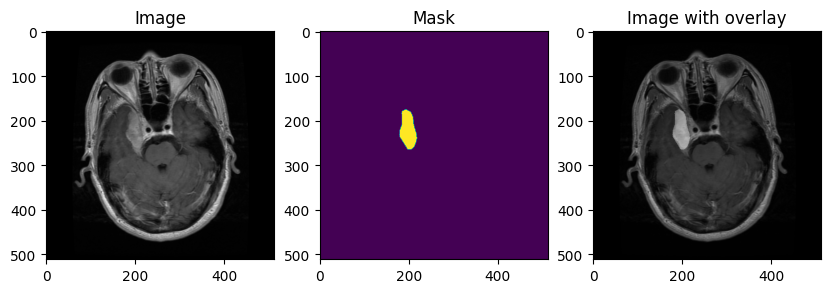

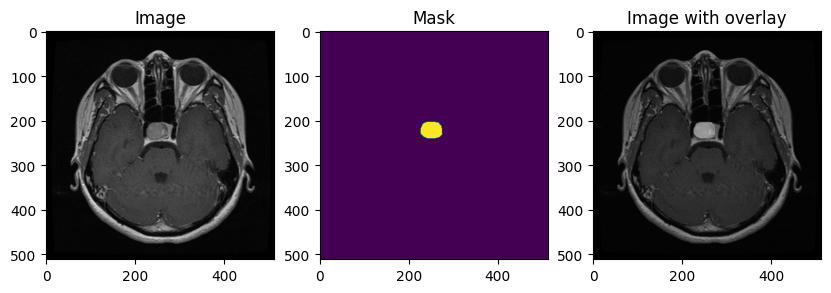

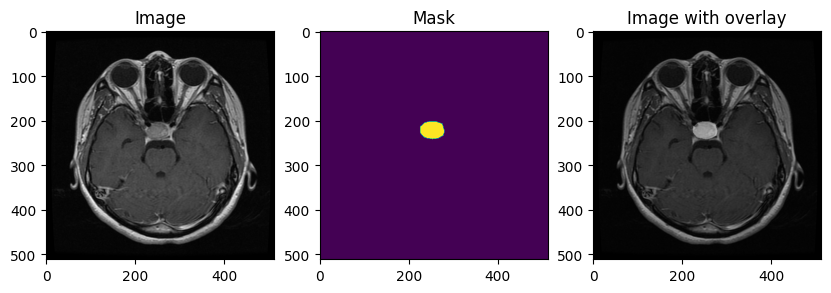

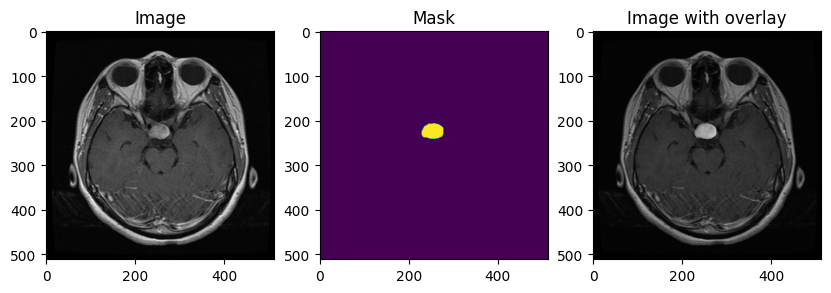

In [6]:
display_image_mask(image_path,mask_path)

In [7]:
image=cv2.imread('/kaggle/input/brain-tumor-segmentation/images/1.png')
mask=cv2.imread('/kaggle/input/brain-tumor-segmentation/masks/1.png')

print(image.shape)
print(mask.shape)

(512, 512, 3)
(512, 512, 3)


# Image and Mask Size

In [8]:
images_size=[]
masks_size=[]

for image_file, mask_file in tqdm(zip(image_files, mask_files)):


    imagepath_full = os.path.join(image_path, image_file)
    maskpath_full = os.path.join(mask_path, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

3064it [00:59, 51.82it/s]


In [9]:
print(list(set(images_size)))
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


# Preprocessing Images 

In [10]:
SIZE=256
CHANNEL=1


In [11]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files,mask_files)):
        imagepathfull=os.path.join(image_path,image_file)
        maskpathfull=os.path.join(mask_path,mask_file)

        image = cv2.imread(imagepathfull,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpathfull,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [12]:
X,y=preprocessing_images_masks()

3064it [00:19, 156.23it/s]


In [13]:
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (3064, 256, 256, 1)
Shape of y: (3064, 256, 256, 1)


# Splitting data into training and testing 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 256, 256, 1)
The shape of y_train (2451, 256, 256, 1)
The shape of X_test (613, 256, 256, 1)
The shape of y_test (613, 256, 256, 1)


# Defining loss function 

In [16]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# U net model

In [17]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=1):
    inputs = keras.layers.Input(input_size)

    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    

In [18]:
# Create and compile the model
model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=1)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])

#summary of the model 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
earlystopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=15, 
                                                 min_lr=1e-7, 
                                                 mode='min')
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint('best_model_checkpoint.keras', save_best_only=True,
                                                        monitor='val_loss', mode='min', verbose=1)

# Training the Model

In [20]:
history=model.fit(X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test, y_test),
          verbose=1, callbacks=[earlystopping,reduce_lr,model_checkpoint])

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0816 - dice_coef: 0.0384 - loss: 0.9616
Epoch 1: val_loss improved from inf to 0.95865, saving model to best_model_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.0823 - dice_coef: 0.0384 - loss: 0.9616 - val_accuracy: 0.4291 - val_dice_coef: 0.0428 - val_loss: 0.9586 - learning_rate: 1.0000e-05
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6737 - dice_coef: 0.0735 - loss: 0.9265
Epoch 2: val_loss improved from 0.95865 to 0.89512, saving model to best_model_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6745 - dice_coef: 0.0737 - loss: 0.9263 - val_accuracy: 0.7735 - val_dice_coef: 0.1096 - val_loss: 0.8951 - learning_rate: 1.0000e-05
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9073 - dice_coef: 0.1625 - loss: 0.8376
Epoch 3: val_loss improved from 0.89512 to 0.72796, saving model to best_model_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

In [21]:
model.save("brain_tumor_segmentation.keras")

# Evaluation

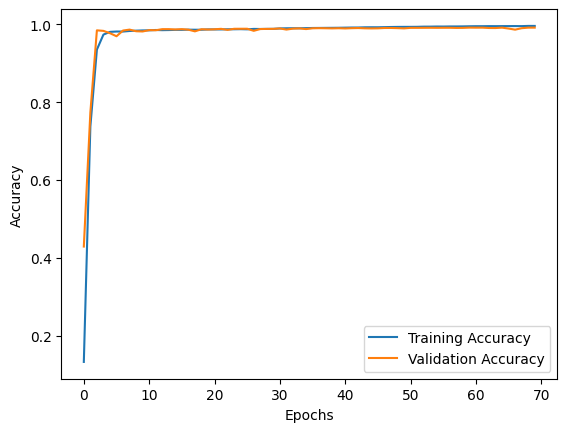

In [22]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

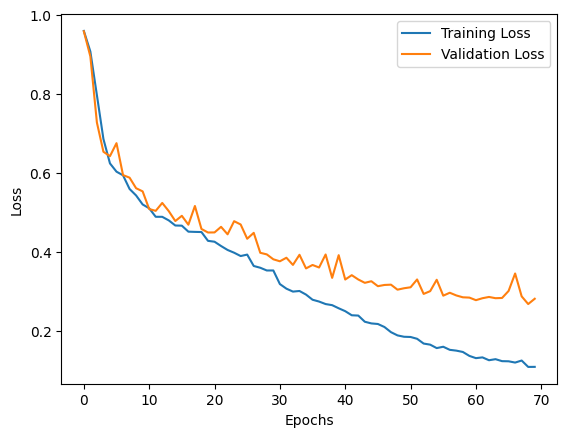

In [23]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.9917 - dice_coef: 0.7195 - loss: 0.2810
Loss is 0.2850463092327118
Accuracy is 0.9914363622665405
Dice_Coef is 0.7197787165641785


# Prediction 

In [25]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step


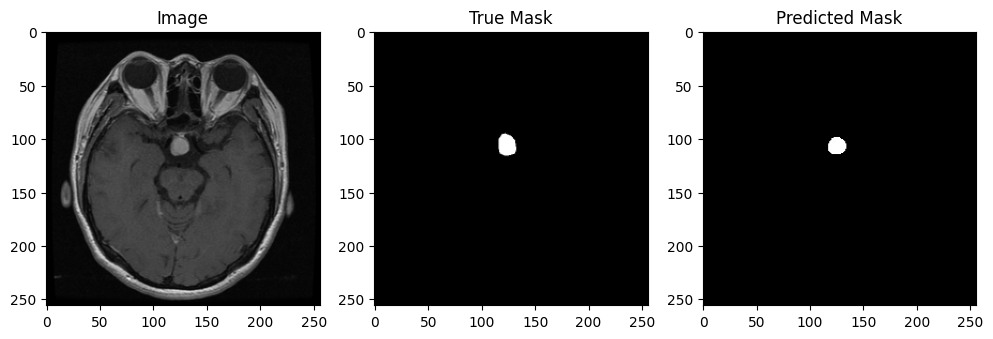

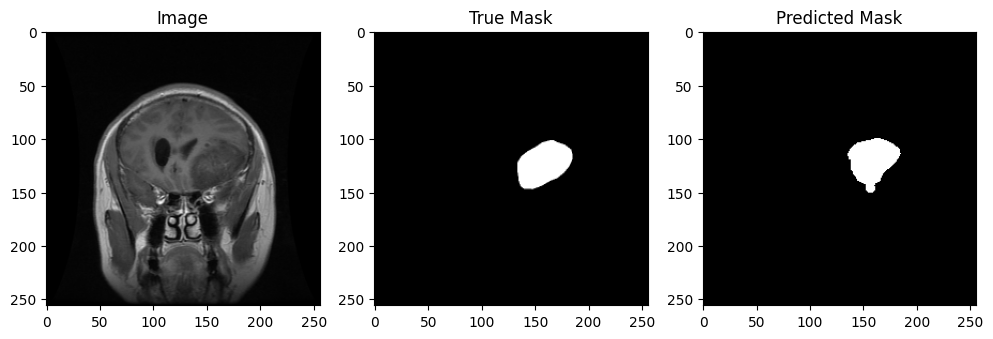

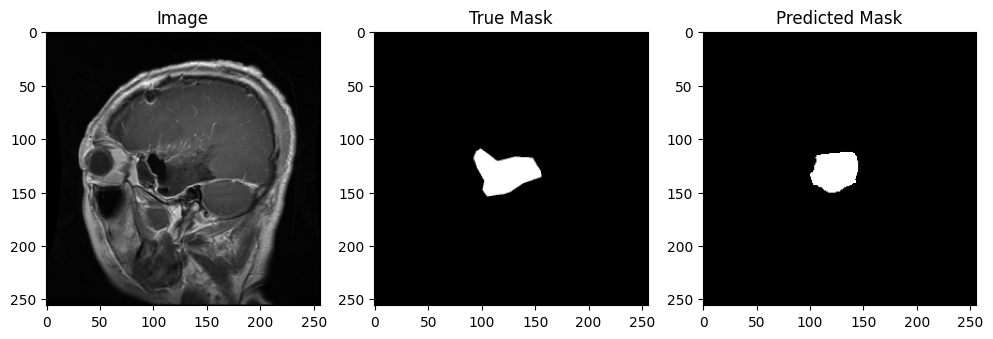

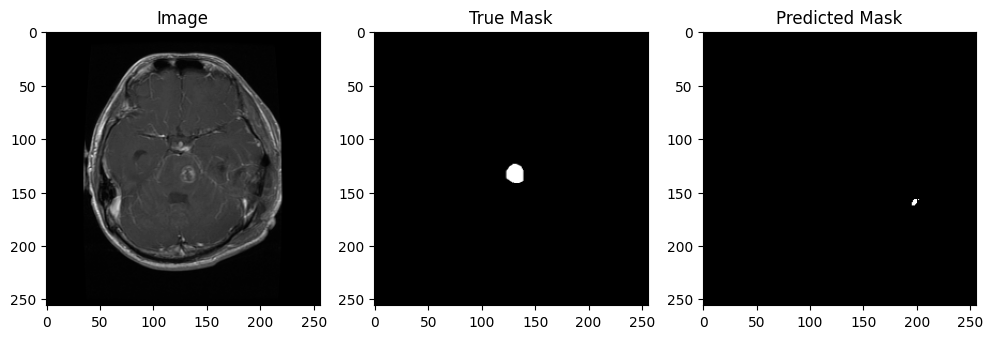

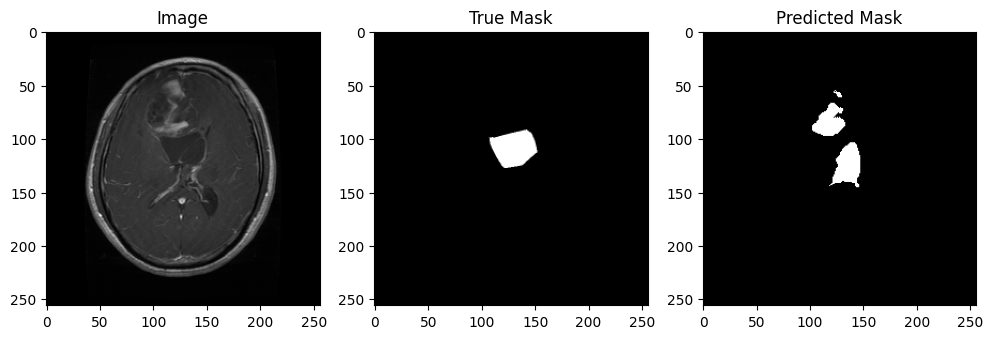

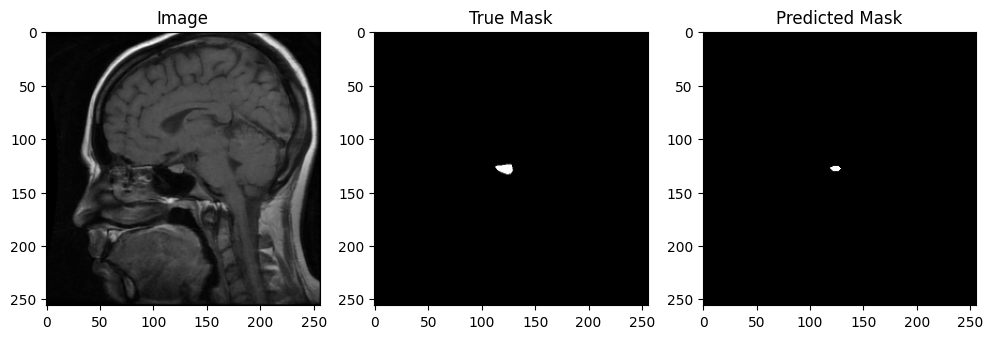

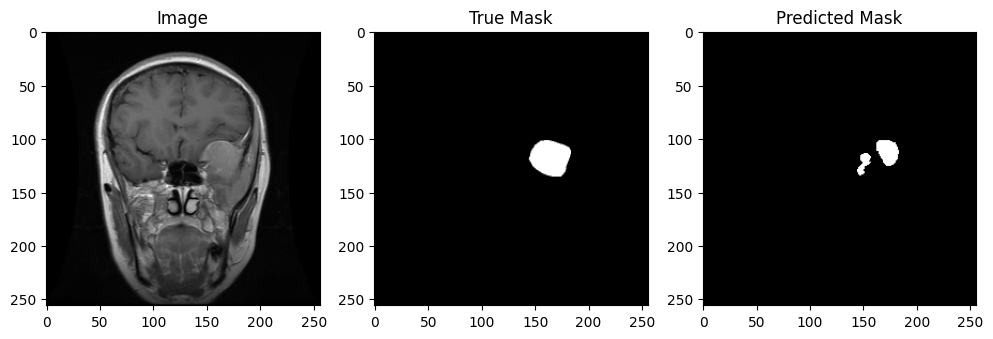

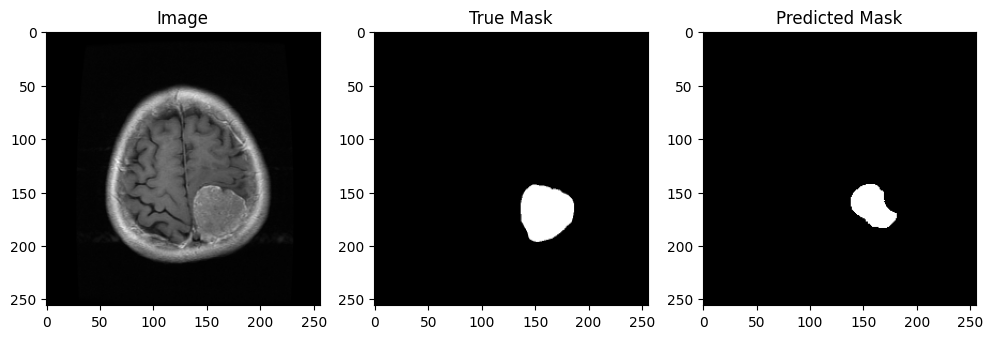

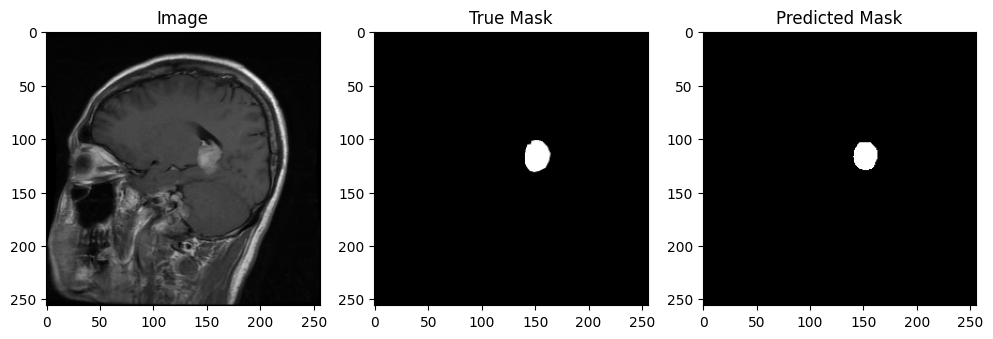

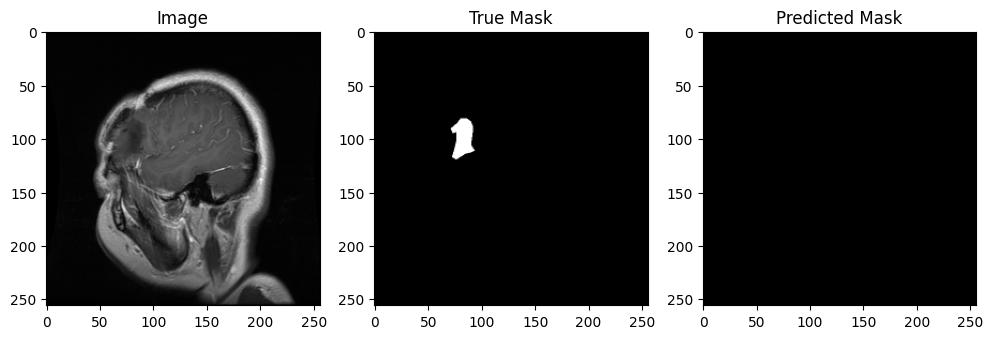

In [26]:
for i in range(10):
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    
    plt.show()